# Combining Neural Networks: *the autoencoders*

## Introduction
So far you have seen different types of Neural Networks, now we will try to combine multiple Neural Networks (NNs) in a single model and train it.
Combining multiple NNs in a single model is often used when we cannot define *a priori* the loss function for the Neural Network we are interested in, but we can train a second NN to approximate that loss function.

The training of the various NNs in a single model can happen separately, or can happen in a single training. Here we will focus on the second, more general (but also more complex case).


## The dataset
Since the topic is relatively advanced, we will discuss it using a very simple dataset: MNIST, a set of $28\times 28$ pixel images representing hand-written digits and letters.

In particular we will use two versions of the MNIST dataset:
 * a set without labels including a large number of digits and letters;
 * a smaller set with labels containing only digits.

We will use the latter to investigate (and at the end to tweak) the behaviour of the Neural Network.

## The problem
Without labels, we cannot expect to train a classifier, but we can try to define a Neural Network mapping images in regions of a ***latent space*** based on their semantic content (here for simplicity the character, either a letter or the digit, they represent).

Unfortunately, without knowing the character of the image during the training, it is difficult to define an algorithm mapping different letters to different regions of the parameter space. What we need is to define an algorithm capable of self-organizing the latent space in a way that similar images (hopefully corresponding to the same character) are closer.

## Autoencoder
We will try to define this algorithm by using two neural networks:
 * an **encoder**, mapping the images to the latent space;
 * a **decoder**, mapping the latent space in the image again.

With this architecture, we can define a loss function for images without label: the input image has to be as similar as possible to the output image.


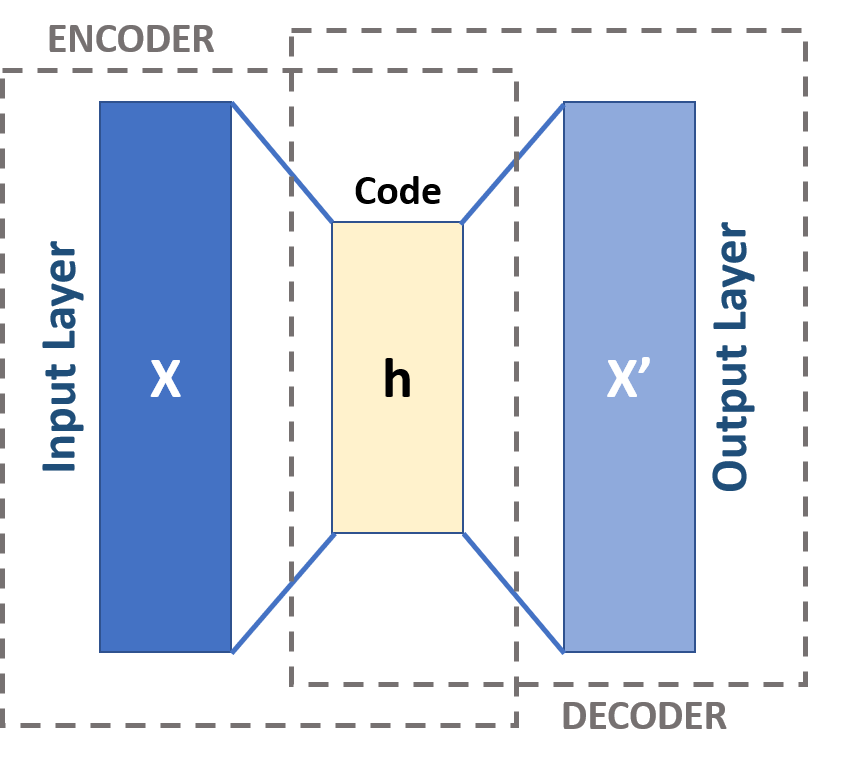


Will this be sufficient to have similar images represented as close entries in the latent space?





## Loading libraries

For this exercise we will use:
 * `numpy` and `matplotlib` as out standard toolkit for manipulating data;
 * `tensorflow` and `Keras` as Deep Learning libraries;
 * `scikit-learn` for the preprocessing steps.

All of these libraries come as preinstalled in Google Colab, se we just need to import them.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

## Obtaining the data

The large unlabeled dataset can be obtained from a private INFN repository (Pandora), while the labeled dataset can be obtained directlry from the `keras.datasets` module.

In [4]:
# Downoad the unlabeled dataset
!wget https://pandora.infn.it/public/d877a8/dl/emnist.npz
emnist_file = np.load("emnist.npz")
chars = np.concatenate([emnist_file['letters'], emnist_file['digits']])

# Download the labeled dataset
(digits_train_raw, label_train), (digits_test_raw, label_test) = tf.keras.datasets.mnist.load_data()

zsh:1: command not found: wget


FileNotFoundError: [Errno 2] No such file or directory: 'emnist.npz'

## Preprocessing

As a first thing, we display the histogram with the pixel values of the two datasets, finding that they are similar (once we normalize the pixel value to the interval 0-1).

In [ ]:
digits_train = digits_train_raw/255
digits_test = digits_test_raw/255

plt.hist(digits_train.flatten(), bins=100, density=True)
plt.hist(chars.flatten(), bins=100, density=True, histtype='step', linewidth=2)
plt.xlabel("Pixel value")
plt.ylabel("Examples")
plt.yscale('log')
plt.show()

Now, to be more effective in the way our Neural Network process the images, it might be a good idea to have a smoother distribution of pixel values instead of two thin peaks at zero and one.

For example, we could apply the inverse of the sigmoid function
$$
y = \frac{1}{1 + \exp(-x)} \quad \to \quad x = \log\left(\frac{y}{1-y}\right)
$$

However, this preprocessing step has two problems:
 1. for pixel values of 0 and 1 it would explode;
 2. applying this transformation implies having values with an arbitrary standard deviation that may also be ineffective in the training.

Hence, we prefer to define in our preprocessing pipeline a preliminary step clipping the pixel value to the interval $\left(\frac{1}{255}, \frac{254}{255}\right)$ and a final to ensure that the standard deviation is 1.

We will define a scikit-learn `Pipeline` object.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

preprocessing_pipeline = Pipeline([
    ("clip", FunctionTransformer(lambda y: np.clip(y, 1/255, 254/255))),
    ("inv_sigmoid", FunctionTransformer(lambda y: np.log(y/(1-y)))),
    ("scaler", StandardScaler(with_mean=False)),
])


The `StandardScaler` forces the standard deviation of the output to 1 with a learnable, linear transformation. The transformation can be learned from data, using the `fit` or `fit_transform` method.

> **Important notice!** This is already part of the training! In real life, never use validation data to perform this step!


### A note on the shapes.
The scikit-learn objects are designed to be applied to tabular data in which each *column* of the table refers to a different variable.

In this case we do not have tabular data, but images!

We have two (extreme) options:
 * treat all the pixel values as a single feature;
 * treat the value of each pixel taken separately as an independent feature.

Depending on what we are doing it might be a better idea to select one of the two strategies. We will use the the former here as it is simpler and less error prone (for example we don't need to correct for tail effects with a pixel being always dark in the whole dataset, breaking the variance computation...).

This means that before applying the preprocessing step we need to transform the dataset in a columnar dataset of shape $(..., 1)$, and after the transformation we need to transform the output columnar dataset back to the original shape.

In [ ]:
chars_pp = preprocessing_pipeline.fit_transform(chars.reshape((-1, 1))).reshape(chars.shape)
digits_train_pp = preprocessing_pipeline.transform(digits_train.reshape((-1, 1))).reshape(digits_train.shape)
digits_test_pp = preprocessing_pipeline.transform(digits_test.reshape((-1, 1))).reshape(digits_test.shape)

The histogram of the preprocessed pixel values is reported below.

In [ ]:
plt.hist(digits_train_pp.flatten(), bins=100, density=True)
plt.hist(chars_pp.flatten(), bins=100, density=True, histtype='step', linewidth=2)
plt.xlabel("Pixel value")
plt.ylabel("Examples")
plt.yscale('log')
plt.show()

# Training a simplified model

Let's start with a simple Autoencoder made only of *dense layers*.

To speed up things, we define an *early stopping* strategy that, after
three epochs without an improvement of the loss (as computed on the training sample) stops the training procedure.

In [ ]:
## Define the encoder with sequential APIs
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.Reshape((28*28,)))
encoder.add(tf.keras.layers.Dense(32, activation='relu'))
encoder.add(tf.keras.layers.Dense(32, activation='relu'))
encoder.add(tf.keras.layers.Dense(2, activation='linear'))

## Define and independent network for the decoder, again with sequential APIs
decoder = tf.keras.Sequential()
decoder.add(tf.keras.layers.Dense(32, activation='tanh'))
decoder.add(tf.keras.layers.Dense(32, activation='tanh'))
decoder.add(tf.keras.layers.Dense(28*28, activation='linear'))
decoder.add(tf.keras.layers.Reshape(digits_train_pp.shape[1:]))

# Using the functional APIs, combine the two neural networks in a single model
X = tf.keras.Input(chars_pp.shape[1:])
autoencoder = tf.keras.Model(inputs=X, outputs=decoder(encoder(X)))


# Define the training strategy:

#  1. early stopping: after three epochs without improvement, stop
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
#  2. Mean Squared Error as loss function, a standard Adam optimizer for loss minimization
autoencoder.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(1e-3))
#  3. Launch the fit by using the same dataset as input AND labels.
history = autoencoder.fit(chars_pp, chars_pp, epochs=100, validation_split=0.1, callbacks=[early_stopping])

We can then plot the loss function as a function of the training epoch.

In [ ]:
display(history.history.keys())
plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

## Visualize the latent space

We can now run the encoder part and plot the latent space. We will draw points of different colors corresponding to the different digits composing our labeled dataset.

We notice that the picture is very difficult to interpret by eye because there are very thin regions where several categories tend to overlap.
This happens because the metric in the latent space is defined in a complicated way and the distance between two points is not related to the semantic difference between the two images.

In [ ]:
encoded = encoder.predict(digits_train_pp)
plt.figure(figsize=(10,10))
for digit in range(10):
  plt.scatter(
      encoded[:,0][label_train==digit],
      encoded[:,1][label_train==digit],
      s=1, label=str(digit)
      )

plt.legend()
plt.show()

## Tweak the latent space

In order to force the latent space to consider two close points as belonging to the same class, we can **add noise**.

Adding Gaussian noise to the latent space we force the decoder network to learn that nearby points carry the same semantic meaning, and we can expect a smoother picture when plotting the classes in the latent space.

But how do we define the noise? A Gaussian, ok, but what should be its standard deviation? The scale of the latent space is random, it is not defined a priori, and therefore the relative scale of the noise is meaningless.

What we need is to normalize the latent space. This has to happen *during the training*. At each epoch, the Neural Network should be trained to renormalize the output of the encoder to ensure its standard deviation is 1.
This can be achieved with a specialized layer named *BatchNormalization*.

*Batch Normalization* is a powerful tool in Deep Learning because it allows to correct drifts in the magnitude of the data while traversing the layers of a Deep Neural Network, helping the convergence of the optimization loop.
In this case, though, we are using *Batch Normalziation* for a differet purpose.

So, in the next code block we are tweaking the Neural Network definition by:
 * adding a `BatchNormalization` layer at the end of the encoder;
 * adding a random noise contribution to the latent space, before the decoder.

In [ ]:
## Define the encoder with sequential APIs
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.Reshape((28*28,)))
encoder.add(tf.keras.layers.Dense(32, activation='relu'))
encoder.add(tf.keras.layers.Dense(32, activation='relu'))
encoder.add(tf.keras.layers.Dense(2, activation='linear'))
encoder.add(tf.keras.layers.BatchNormalization())

## Define and independent network for the decoder, again with sequential APIs
decoder = tf.keras.Sequential()
decoder.add(tf.keras.layers.Dense(32, activation='tanh'))
decoder.add(tf.keras.layers.Dense(32, activation='tanh'))
decoder.add(tf.keras.layers.Dense(28*28, activation='linear'))
decoder.add(tf.keras.layers.Reshape(digits_train_pp.shape[1:]))

# Using the functional APIs, combine the two neural networks in a single model
X = tf.keras.Input(chars_pp.shape[1:])
# Define the noise for the latent space (dimension: 2)
r = tf.keras.random.normal(shape=(2,), stddev=1)
autoencoder = tf.keras.Model(inputs=X, outputs=decoder(r+encoder(X)))


# Define the training strategy:

#  1. early stopping: after three epochs without improvement, stop
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
#  2. Mean Squared Error as loss function, a standard Adam optimizer for loss minimization
autoencoder.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(1e-3))
#  3. Launch the fit by using the same dataset as input AND labels.
history = autoencoder.fit(chars_pp, chars_pp, epochs=100, validation_split=0.1, callbacks=[early_stopping])

At this point the picture is indeed smoother and it is more evident that similar images are mapped to the same region of the latent space.



In [ ]:
encoded = encoder.predict(digits_train_pp)
plt.figure(figsize=(10,10))
for digit in range(10):
  plt.scatter(
      encoded[:,0][label_train==digit],
      encoded[:,1][label_train==digit],
      s=1, label=str(digit)
      )

plt.legend()
plt.show()

# Let's pin labels in the latent space!

Now that we have a simple Autoencoder working we can play with it and try to evolve it adding information or constraining the training procedure.

We will treat here one of the most advanced cases, suggesting other evolutions for personal practice: pinning labels of a fraction of the dataset in the latent space.

The idea is that we can train the Neural Network on a partially labeled dataset. We rely on the labeled fraction to define where, those samples, must be mapped in the latent space, and on the Autoencoder semisupervised learning to cluster close to those points the similar entries.

In practice, we are training against two different losses computed on two different outputs:
 * A Mean Squared Error computed on all samples measuring the quality of the autoencoder reconstruction;
 * A Mean Squared Error computed only on the labeld samples measuring the error between the chosen point in the latent space and a *pin*, or a position chosen based on the label.

 For example, we will use as pin for the digit $d \in {0, 1, 2, ..., 9}$ the position $\left(\cos\frac{2d\pi}{10}, \sin\frac{2d\pi}{10}\right)$.



In [ ]:
## Define the encoder with sequential APIs
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.Reshape((28*28,)))
encoder.add(tf.keras.layers.Dense(32, activation='relu'))
encoder.add(tf.keras.layers.Dense(32, activation='relu'))
encoder.add(tf.keras.layers.Dense(2, activation='linear'))
encoder.add(tf.keras.layers.BatchNormalization())

## Define and independent network for the decoder, again with sequential APIs
decoder = tf.keras.Sequential()
decoder.add(tf.keras.layers.Dense(32, activation='tanh'))
decoder.add(tf.keras.layers.Dense(32, activation='tanh'))
decoder.add(tf.keras.layers.Dense(28*28, activation='linear'))
decoder.add(tf.keras.layers.Reshape(digits_train_pp.shape[1:]))

# Using the functional APIs, combine the two neural networks in a single model
X = tf.keras.Input(chars_pp.shape[1:])
# Define the noise for the latent space (dimension: 2)
r = tf.keras.random.normal(shape=(2,), stddev=1)

# NB! Here we define two outputs: for the encoder and the decoder separately.
autoencoder = tf.keras.Model(inputs=X, outputs=dict(decoded=decoder(r+encoder(X)), encoded=encoder(X)))



early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# NB! We are using a new dataset, obtained combining the labeled and unlabeled data
full_dataset = np.concatenate([chars_pp, digits_train_pp], axis=0)
pin = np.c_[
    np.concatenate([np.zeros(len(chars_pp)), np.cos(2*np.pi/10*label_train)]),
    np.concatenate([np.zeros(len(chars_pp)), np.sin(2*np.pi/10*label_train)]),
]

# NB! We are defining a custom loss. MSE if the label is defined, zero otherwise.
def maybe_mse(y_true, y_pred):
  mse = tf.keras.losses.MeanSquaredError()
  return  tf.reduce_sum(tf.square(y_true), axis=1) * mse(y_true, y_pred)

# NB! Here we define the two losses
autoencoder.compile(loss=dict(encoded=maybe_mse, decoded="mse"), optimizer=tf.keras.optimizers.Adam(1e-3))

# NB! And the two values of y_pred to pass to the loss itself.
history = autoencoder.fit(full_dataset, dict(decoded=full_dataset, encoded=pin), epochs=100, validation_split=0.1, callbacks=[early_stopping], batch_size=1000)

In [ ]:
encoded = encoder.predict(digits_train_pp)
plt.figure(figsize=(10,10))
for digit in range(10):
  plt.scatter(
      encoded[:,0][label_train==digit],
      encoded[:,1][label_train==digit],
      s=1, label=str(digit)
      )

plt.legend()
plt.show()

# Exercises (or relevant evolutions)

1. Try to balance between the loss functions on the decoded and latent space by weighting them by a constant to to push the training in the two directions.
2. What happens if you use `tanh` activation functions in the encoder? Can you guess why?
3. Autoencoders on images may profit of the Convolutional Layers. Try to define a Convolutional Autoencoder to perform the same task and compare the performance.
4. Instead (or in addition) of defining the pins in the latent space, you can train a classifier to distiguish between the latent space and a randomly generated point, and then train the encoder to reduce the loss of this classifier. This architecture is named [Adversarial Variational Autoencoder](https://arxiv.org/pdf/2012.11551) and is a Generative Model (**Warning!** This may require editing the training loop instead of using the `fit` method! Hints [here](github.com/landerlini/algherogans)).
5. Increasing the number of axes in the latent space you would loose the opportunity of plotting the categories, but the autoencoder would require a minor level of compression and the reconstruction loss would improve. Try to verify it.



